### test

In [3]:
import os
import cv2

# Directory path of the images
image_dir = 'test'

# Output directory path to save the reshaped images
output_dir = 'test'

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Reshape and save each image
for filename in os.listdir(image_dir):
    # Read the image
    image_path = os.path.join(image_dir, filename)
    image = cv2.imread(image_path)

    # Reshape the image to (2255, 3151)
    reshaped_image = cv2.resize(image, (2255, 3151))

    # Save the reshaped image
    output_path = os.path.join(output_dir, filename)
    cv2.imwrite(output_path, reshaped_image)

print("Images reshaped and saved successfully.")

Images reshaped and saved successfully.


In [2]:
import cv2 
import numpy as np
from math import atan2, degrees, tan, radians, cos
import imutils


def detect_corner(img_path: str): 
    # Load the image
    image = cv2.imread(img_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 60, 200, cv2.THRESH_BINARY_INV)[1]

    # Find contours and sort by area
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:4]  # Take 4 largest contours

    centroids = []

    # Calculate centroids of the largest contours
    for c in cnts:
        (x, y, w, h) = cv2.boundingRect(c)
        cX = int(x + w / 2)
        cY = int(y + h / 2)
        centroids.append((cX, cY))

    # Sort centroids by X-coordinate (left to right)
    centroids_sorted = sorted(centroids, key=lambda x: x[0])

    # Points A and B (leftmost centroids)
    x1, y1 = centroids_sorted[0]  # Top-left corner
    x2, y2 = centroids_sorted[1]  # Top-right corner

    # Vector AB
    AB_dx = x2 - x1
    AB_dy = y2 - y1

    # Calculate angle between AB and the Y-axis
    angle_AB_Oy = degrees(atan2(AB_dx, AB_dy))  # Angle in degrees

    # Adjust angle to [-90°, 90°]
    corrected_angle = -angle_AB_Oy if angle_AB_Oy < 90 else 180 - angle_AB_Oy
    return radians(corrected_angle)  # Return angle in radians



In [4]:
from tqdm.auto import tqdm
from ultralytics import YOLO
import os
model = YOLO('models/best_yolo11l_noadding.pt')
dataset_dir = 'test'
out_dir = 'test'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
for img in tqdm(os.listdir(dataset_dir)):
    img_path = os.path.join(dataset_dir, img)
    results = model.predict(img_path, stream = True)
    # angle_diff = detect_corner(img_path)
    test_result = []

    for result in results:
        result = result.boxes
        classes = (result.cls.cpu().detach().numpy())
        confs = (result.conf.cpu().detach().numpy())
        res_boxes = (result.xywhn.cpu().detach().numpy())

        classes = [str(int(c)) for c in classes]
        confs = [str(float(c)) for c in confs]
        res_boxes = [" ".join(map(str, row)) for row in res_boxes]

        for i in range(len(classes)):
            test_result.append(classes[i]  + " " + res_boxes[i])
        break
    img = img.replace('.jpg', '.txt')
    with open(f'{out_dir}/{img}', 'w') as f:
        for item in test_result:
            f.write("%s\n" % item)
        # f.write(f'angle_diff {angle_diff}\n')
    
    


  0%|          | 0/1 [00:00<?, ?it/s]


image 1/1 /home/quangminh/Documents/code/Python/AMICAIChallenge/test/sheet1.jpg: 1280x928 106 blacks, 194 whites, 127.4ms


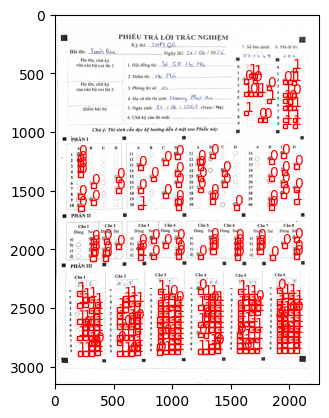

In [5]:
import matplotlib.pyplot as plt

# Path to the testing image
image_path = 'test/sheet1.jpg'

# Path to the .txt file containing the coordinates
txt_file_path = 'test/sheet1.txt'

# Load the image
image = plt.imread(image_path)

# Create a figure and axis
fig, ax = plt.subplots()

# Display the image
ax.imshow(image)

# Read the coordinates from the .txt file
with open(txt_file_path, 'r') as f:
    lines = f.readlines()

for line in lines:
    line = line.strip().split()
    class_label = line[0]
    x, y, width, height = map(float, line[1:])

    # Convert the coordinates to pixel values
    x_pixel = x * image.shape[1]
    y_pixel = y * image.shape[0]
    width_pixel = width * image.shape[1]
    height_pixel = height * image.shape[0]

    # Create a rectangle patch
    rect = plt.Rectangle((x_pixel, y_pixel), width_pixel, height_pixel, edgecolor='r', facecolor='none')

    # Add the rectangle patch to the axis
    ax.add_patch(rect)

    # Add a label to the rectangle
    ax.text(x_pixel, y_pixel, class_label, color='r')

# Show the image with the bounding boxes
plt.show()

In [4]:
model.info()

YOLO11l summary (fused): 464 layers, 25,280,854 parameters, 0 gradients, 86.6 GFLOPs


(464, 25280854, 0, 86.5829376)

In [5]:
# import numpy as np

# def rotate_boundary(coordinates, angle_radians, img_height, img_width):
#     """
#     Rotate bounding boxes based on an angle.
    
#     Args:
#         coordinates (dict): Dictionary of normalized bounding box coordinates.
#                             Format: {key: ((h_min, h_max), (w_min, w_max))}
#         angle_radians (float): Rotation angle in radians (from detect_corner()).
#         img_height (int): Height of the image.
#         img_width (int): Width of the image.
    
#     Returns:
#         dict: Rotated bounding boxes in the same format as input.
#     """
#     cos_theta = np.cos(angle_radians)
#     sin_theta = np.sin(angle_radians)
#     center_x = img_width / 2
#     center_y = img_height / 2

#     rotated_coordinates = {}

#     for key, ((h_min, h_max), (w_min, w_max)) in coordinates.items():
#         # Convert normalized to absolute coordinates
#         h_min_abs = h_min * img_height
#         h_max_abs = h_max * img_height
#         w_min_abs = w_min * img_width
#         w_max_abs = w_max * img_width

#         # Define the four corners of the bounding box
#         corners = [
#             (w_min_abs, h_min_abs),  # Top-left
#             (w_min_abs, h_max_abs),  # Bottom-left
#             (w_max_abs, h_min_abs),  # Top-right
#             (w_max_abs, h_max_abs),  # Bottom-right
#         ]

#         # Rotate each corner
#         rotated_corners = []
#         for x, y in corners:
#             # Translate point to the origin (center of the image)
#             x_shifted = x - center_x
#             y_shifted = y - center_y

#             # Apply rotation matrix
#             x_rot = cos_theta * x_shifted - sin_theta * y_shifted
#             y_rot = sin_theta * x_shifted + cos_theta * y_shifted

#             # Translate back to the original coordinate system
#             x_rot += center_x
#             y_rot += center_y

#             rotated_corners.append((x_rot, y_rot))

#         # Get new bounding box from rotated corners
#         x_coords = [corner[0] for corner in rotated_corners]
#         y_coords = [corner[1] for corner in rotated_corners]

#         new_w_min = min(x_coords) / img_width
#         new_w_max = max(x_coords) / img_width
#         new_h_min = min(y_coords) / img_height
#         new_h_max = max(y_coords) / img_height

#         # Save the rotated bounding box in normalized form
#         rotated_coordinates[key] = ((new_h_min, new_h_max), (new_w_min, new_w_max))

#     return rotated_coordinates


In [6]:
# import os
# import copy 
# # test for process the result 

# label_dirs = 'datasets/finaltest_500/labels'
# ROTATE = False

# coordinates = {
#     'SBD1': ((400/3151, 1000/3151), (1500/2255, 1630/2255)),
#     'SBD2': ((400/3151, 1000/3151), (1630/2255, 1670/2255)),
#     'SBD3': ((400/3151, 1000/3151), (1670/2255, 1710/2255)),
#     'SBD4': ((400/3151, 1000/3151), (1710/2255, 1750/2255)),
#     'SBD5': ((400/3151, 1000/3151), (1750/2255, 1790/2255)),
#     'SBD6': ((400/3151, 1000/3151), (1790/2255, 1830/2255)),
#     'MDT1': ((400/3151, 1000/3151), (1860/2255, 1950/2255)),
#     'MDT2': ((400/3151, 1000/3151), (1950/2255, 1990/2255)),
#     'MDT3': ((400/3151, 1000/3151), (1990/2255, 2030/2555)),

#     '1.1': ((1170/3151, 1220/3151), (170/2255, 650/2255)),
#     '1.2': ((1220/3151, 1270/3151), (170/2255, 650/2255)),
#     '1.3': ((1270/3151, 1320/3151), (170/2255, 650/2255)),
#     '1.4': ((1320/3151, 1370/3151), (170/2255, 650/2255)),
#     '1.5': ((1370/3151, 1420/3151), (170/2255, 650/2255)),
#     '1.6': ((1420/3151, 1470/3151), (170/2255, 650/2255)),
#     '1.7': ((1470/3151, 1520/3151), (170/2255, 650/2255)),
#     '1.8': ((1520/3151, 1570/3151), (170/2255, 650/2255)),
#     '1.9': ((1570/3151, 1620/3151), (170/2255, 650/2255)),
#     '1.10': ((1620/3151, 1670/3151), (170/2255, 650/2255)),

#     '1.11': ((1170/3151, 1220/3151), (670/2255, 1080/2255)),
#     '1.12': ((1220/3151, 1270/3151), (670/2255, 1080/2255)),
#     '1.13': ((1270/3151, 1320/3151), (670/2255, 1080/2255)),
#     '1.14': ((1320/3151, 1370/3151), (670/2255, 1080/2255)),
#     '1.15': ((1370/3151, 1420/3151), (670/2255, 1080/2255)),
#     '1.16': ((1420/3151, 1470/3151), (670/2255, 1080/2255)),
#     '1.17': ((1470/3151, 1520/3151), (670/2255, 1080/2255)),
#     '1.18': ((1520/3151, 1570/3151), (670/2255, 1080/2255)),
#     '1.19': ((1570/3151, 1620/3151), (670/2255, 1080/2255)),
#     '1.20': ((1620/3151, 1670/3151), (670/2255, 1080/2255)),

#     '1.21': ((1170/3151, 1220/3151), (1000/2255, 1580/2255)),
#     '1.22': ((1220/3151, 1270/3151), (1000/2255, 1580/2255)),
#     '1.23': ((1270/3151, 1320/3151), (1000/2255, 1580/2255)),
#     '1.24': ((1320/3151, 1370/3151), (1000/2255, 1580/2255)),
#     '1.25': ((1370/3151, 1420/3151), (1000/2255, 1580/2255)),
#     '1.26': ((1420/3151, 1470/3151), (1000/2255, 1580/2255)),
#     '1.27': ((1470/3151, 1520/3151), (1000/2255, 1580/2255)),
#     '1.28': ((1520/3151, 1570/3151), (1000/2255, 1580/2255)),
#     '1.29': ((1570/3151, 1620/3151), (1000/2255, 1580/2255)),
#     '1.30': ((1620/3151, 1670/3151), (1000/2255, 1580/2255)),

#     '1.31': ((1170/3151, 1220/3151), (1580/2255,2050/2255)),
#     '1.32': ((1220/3151, 1270/3151), (1580/2255,2050/2255)),
#     '1.33': ((1270/3151, 1320/3151), (1580/2255,2050/2255)),
#     '1.34': ((1320/3151, 1370/3151), (1580/2255,2050/2255)),
#     '1.35': ((1370/3151, 1420/3151), (1580/2255,2050/2255)),
#     '1.36': ((1420/3151, 1470/3151), (1580/2255,2050/2255)),
#     '1.37': ((1470/3151, 1520/3151), (1580/2255,2050/2255)),
#     '1.38': ((1520/3151, 1570/3151), (1580/2255,2050/2255)),
#     '1.39': ((1570/3151, 1620/3151), (1580/2255,2050/2255)),
#     '1.40': ((1620/3151, 1670/3151), (1580/2255,2050/2255)),

#     '2.1': ((1750/3151, 2100/3151), (160/2255, 400/2255)),
#     '2.2': ((1750/3151, 2100/3151), (400/2255, 630/2255)),
#     '2.3': ((1750/3151, 2100/3151), (630/2255, 880/2255)),
#     '2.4': ((1750/3151, 2100/3151), (880/2255, 1130/2255)),
#     '2.5': ((1750/3151, 2100/3151), (1130/2255, 1380/2255)),
#     '2.6': ((1750/3151, 2100/3151), (1380/2255, 1610/2255)),
#     '2.7': ((1750/3151, 2100/3151), (1610/2255, 1830/2255)),
#     '2.8': ((1750/3151, 2100/3151), (1830/2255, 2050/2255)),

#     '3.1': ((2050/3151, 2900/3151), (100/2255, 490/2255)),    
#     '3.2': ((2050/3151, 2900/3151), (490/2255, 800/2255)),
#     '3.3': ((2050/3151, 2900/3151), (800/2255, 1110/2255)),
#     '3.4': ((2050/3151, 2900/3151), (1110/2255, 1420/2255)),
#     '3.5': ((2050/3151, 2900/3151), (1420/2255, 1730/2255)),
#     '3.6': ((2050/3151, 2900/3151), (1730/2255, 2040/2255)),
# }


# output_lines = []
# for k in range(len(os.listdir(label_dirs))): 

#     with open(f'{label_dirs}/{os.listdir(label_dirs)[k]}', 'r') as f:
#         lines = f.readlines() 
#         for line in lines: 
#             line = line.replace('\n', '').split()
    
#     output = copy.copy(coordinates)
#     for i in output: 
#         output[i] = []
    
#     # angle_diff = float(lines[-1].split()[1])
#     # if ROTATE:
#     #     coordinates = rotate_boundary(coordinates, angle_diff, 3151, 2255)
#     for line in lines: 
#         # if 'angle_diff' not in line:
#         width_center, height_center = float(line.split()[1]), float(line.split()[2])
#         for key in coordinates: 
#             height_min, height_max, width_min, width_max = coordinates[key][0][0], coordinates[key][0][1], coordinates[key][1][0], coordinates[key][1][1]
#             if width_min <= width_center and width_max >= width_center and height_min<=height_center and height_max >= height_center: 
#                 if int(line.split()[0]) == 0:
#                     output[key].append(','.join([f'{float(num):.6f}' for num in line.split()[1:]]))
#     img = os.listdir(label_dirs)[k].replace('.txt', '.jpg')
#     line = []
#     for key, items in output.items(): 
#         if len(items)>0:
#             boxes = f'{key} {' '.join(items)}'
#             line.append(boxes)
#     output_lines.append(f'{img} {' '.join(line)}')

# print(len(output_lines))
# # Dump converted lines into a txt file
# output_file = 'results.txt'  # Replace with your desired output file path
# with open(output_file, 'w') as f:
#     for line in output_lines:
#         f.write(line + '\n')
# print(f'Converted lines have been saved to {output_file}')


500
Converted lines have been saved to results.txt
